# eROSITA Miscentering Distribution Analisis

## Introduzione

All'interno di questo breve elaborato si analizzeranno i dati ottenuti dalla survey di eROSITA con lo scopo principale di studiare la miscentering distribution degli ammassi di galassie. 
Con questo obiettivo è stato sviluppato un breve script in python che consente di elaborare i dati della survey basandosi su librerie atte all'analisi e alla rappresentazione dei dati.

Il codice è stato suddiviso per facilitare la lettura nelle seguenti macroaree:
1. **Analisi del catalogo**: estrazione, selezione e prima analisi dati
    - Lettura e selezione dati
    - Analisi della distribuzione delle distanze normalizzate
        - Distribuzione dei dati
        - Variazione distribuzione in funzione di massa e redsift
2. **Sviluppo dei modelli**: studio dei modelli descrittivi della distribuzione
    - Rappresentazione del modello *S15* al variare dei parametri
    - Rappresentazione del modello *Z19* al variare dei parametri
3. **Analisi Bayesiana**: verifica dell'accuratezza dei modelli per la rappresentazione dei dati
    - Modello *S15*
        - Fitting dei parametri con algoritmo emcee
        - Confronto dati - modello
        - Valutazione della riproducibilità dei dati mediante il modello
    - Modello *Z19*
        - Fitting dei parametri con algoritmo emcee
        - Confronto dati - modello
        - Valutazione della riproducibilità dei dati mediante il modello
    

Importazione delle librerie necessarie

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
from scipy.optimize import minimize
import pygtc

## 1. Analisi del catalogo

### Lettura e selezione dati

Creazione di un dataframe pandas contenente i dati dal file .csv 

In [46]:
data = pd.read_csv('catalog_selected_columns_filtered_with_cluster_index.csv')
data

,Unnamed: 0,NAME,RA_XFIT,DEC_XFIT,M500,R500,RA_OPT,DEC_OPT,RA_BCG,DEC_BCG,...,X_scaled_0,X_scaled_1,cluster,rho_m,rho_s,sigma0_m,sigma0_s,sigma1_m,sigma1_s,logM500
0,0,1eRASS J000005.2-383729,0.0214,-38.6250,36.07,971.0,0.023800,-38.626781,0.023800,-38.626781,...,-0.081623,0.778435,6,0.750582,0.027508,0.100183,0.007995,0.668959,0.040839,14.557146
1,1,1eRASS J000021.4-824954,0.0558,-82.8189,16.99,819.0,0.176800,-82.798203,0.176800,-82.798203,...,-1.230286,-0.425019,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.230193
2,2,1eRASS J000031.8-630131,0.1265,-63.0225,22.04,846.0,0.125400,-63.023071,0.125400,-63.023071,...,-0.439542,-0.046329,9,0.809312,0.024625,0.089089,0.006957,0.578245,0.038856,14.343212
3,3,1eRASS J000056.7-682010,0.2309,-68.3369,14.25,732.0,0.230100,-68.336777,0.176500,-68.372871,...,-0.456453,-0.657230,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.153815
4,4,1eRASS J000104.0-464435,0.2768,-46.7381,23.84,891.0,0.284000,-46.734661,0.284000,-46.734661,...,-0.809294,0.075927,22,0.779619,0.029719,0.058439,0.005577,0.514526,0.037597,14.377306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,7703,1eRASS J235805.6-403027,359.5230,-40.5073,11.51,692.0,359.557709,-40.486210,359.557709,-40.486210,...,-0.670809,-0.913151,26,0.779278,0.026525,0.103519,0.008066,0.620830,0.038000,14.061075
7563,7704,1eRASS J235848.7-612554,359.7070,-61.4319,21.82,800.0,359.700287,-61.433041,359.700287,-61.433041,...,0.278480,-0.061689,29,0.768367,0.033628,0.181056,0.018008,0.775150,0.052974,14.338855
7564,7705,1eRASS J235858.0-603644,359.6968,-60.6172,38.67,1071.0,359.767090,-60.609489,359.618896,-60.563850,...,-1.148322,0.905424,2,0.730593,0.032936,0.039728,0.003903,0.506667,0.035547,14.587374
7565,7706,1eRASS J235927.5-341821,359.8642,-34.3077,14.11,763.0,359.865387,-34.306438,359.865387,-34.306438,...,-1.104801,-0.669692,7,0.726530,0.026114,0.062899,0.005056,0.606223,0.031481,14.149527


Estrazione dei dati di interesse

In [47]:
data = data.loc[:, ['BEST_Z', 'logM500', 'BCG_offset_R500']]
data.head(10)

,BEST_Z,logM500,BCG_offset_R500
0,0.31528,14.557146,0.044778
1,0.08909,14.230193,0.189587
2,0.24480,14.343212,0.012553
3,0.24147,14.153815,0.781392
4,0.17199,14.377306,0.071918
5,0.30403,14.217484,1.415935
6,0.32467,14.469822,0.291822
7,0.18463,13.889862,1.193630
8,0.23010,14.101403,0.037132
9,0.33544,14.155943,0.138859


### Analisi della distribuizone delle distanze normalizzate

#### Distribuzione dati

array([[<Axes: title={'center': 'BCG_offset_R500'}>]], dtype=object)

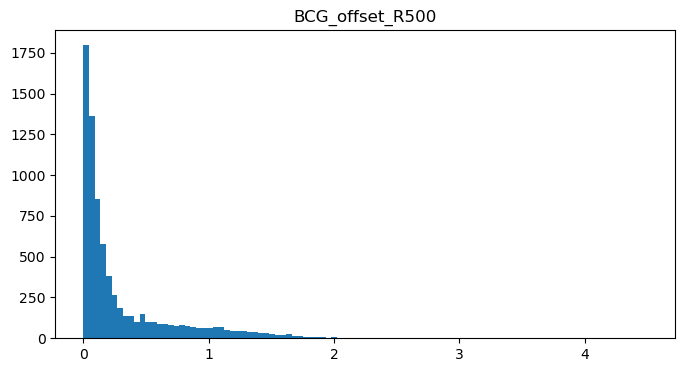

In [48]:
data.hist(column='BCG_offset_R500', bins=100, grid=False, figsize=(8,4))

si osserva un decadimento circa esponenziale con la distanza 

#### Analisi distribuzione in funzione di redshift e massa 

suddivisione dei valori in intervalli

In [49]:
data['logM500_binned'] = pd.cut(data['logM500'], bins=50)
data['BEST_Z_binned'] = pd.cut(data['BEST_Z'], bins=50)
data['BCG_offset_R500_binned'] = pd.cut(data['BCG_offset_R500'], bins=50)
data.head(10)

,BEST_Z,logM500,BCG_offset_R500,logM500_binned,BEST_Z_binned,BCG_offset_R500_binned
0,0.31528,14.557146,0.044778,"(14.518, 14.567]","(0.312, 0.334]","(-0.00367, 0.0908]"
1,0.08909,14.230193,0.189587,"(14.221, 14.271]","(0.0719, 0.0937]","(0.181, 0.271]"
2,0.24480,14.343212,0.012553,"(14.32, 14.37]","(0.225, 0.247]","(-0.00367, 0.0908]"
3,0.24147,14.153815,0.781392,"(14.123, 14.172]","(0.225, 0.247]","(0.72, 0.81]"
4,0.17199,14.377306,0.071918,"(14.37, 14.419]","(0.159, 0.181]","(-0.00367, 0.0908]"
5,0.30403,14.217484,1.415935,"(14.172, 14.221]","(0.29, 0.312]","(1.35, 1.44]"
6,0.32467,14.469822,0.291822,"(14.468, 14.518]","(0.312, 0.334]","(0.271, 0.361]"
7,0.18463,13.889862,1.193630,"(13.876, 13.925]","(0.181, 0.203]","(1.17, 1.26]"
8,0.23010,14.101403,0.037132,"(14.073, 14.123]","(0.225, 0.247]","(-0.00367, 0.0908]"
9,0.33544,14.155943,0.138859,"(14.123, 14.172]","(0.334, 0.356]","(0.0908, 0.181]"


Creazione della griglia di valori per l'istogramma 3D
- raggruppamento dei dati in funzione delle possibili coppie di intervalli massa-distanza (verifica di quali valori rientrano all'interno della porzione di superficie definita dal prodotto degli intervalli in uno spazio 2D)
- conteggio dei valori raggruppati 
- creazione di un dataframe in cui per ogni cella si ha un valore (unstack apre il dataframe precedente e riempie ogni cella per cui si ha un conteggio non nullo con il rispettivo valore mentre quelle nulle sono automaticamente impostate a 0)

In [50]:
hist_mass_data = data.groupby(['logM500_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()
hist_mass_data.head(10)

C:\Users\gioch\AppData\Local\Temp\ipykernel_14752\2047454251.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist_mass_data = data.groupby(['logM500_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()


BCG_offset_R500_binned,"(-0.00367, 0.0908]","(0.0908, 0.181]","(0.181, 0.271]","(0.271, 0.361]","(0.361, 0.451]","(0.451, 0.541]","(0.541, 0.63]","(0.63, 0.72]","(0.72, 0.81]","(0.81, 0.9]",...,"(3.599, 3.689]","(3.689, 3.779]","(3.779, 3.868]","(3.868, 3.958]","(3.958, 4.048]","(4.048, 4.138]","(4.138, 4.228]","(4.228, 4.318]","(4.318, 4.408]","(4.408, 4.498]"
logM500_binned,,,,,,,,,,,,,,,,,,,,,
"(12.738, 12.79]",0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
"(12.79, 12.839]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(12.839, 12.888]",0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(12.888, 12.938]",0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
"(12.938, 12.987]",0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
"(12.987, 13.037]",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(13.037, 13.086]",1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(13.086, 13.135]",3,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
"(13.135, 13.185]",1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
hist_z_data = data.groupby(['BEST_Z_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()
hist_z_data.head(10)

C:\Users\gioch\AppData\Local\Temp\ipykernel_14752\2266038405.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist_z_data = data.groupby(['BEST_Z_binned', 'BCG_offset_R500_binned'])['BCG_offset_R500_binned'].count().unstack()


BCG_offset_R500_binned,"(-0.00367, 0.0908]","(0.0908, 0.181]","(0.181, 0.271]","(0.271, 0.361]","(0.361, 0.451]","(0.451, 0.541]","(0.541, 0.63]","(0.63, 0.72]","(0.72, 0.81]","(0.81, 0.9]",...,"(3.599, 3.689]","(3.689, 3.779]","(3.779, 3.868]","(3.868, 3.958]","(3.958, 4.048]","(4.048, 4.138]","(4.138, 4.228]","(4.228, 4.318]","(4.318, 4.408]","(4.408, 4.498]"
BEST_Z_binned,,,,,,,,,,,,,,,,,,,,,
"(0.0489, 0.0719]",133,13,10,4,2,6,7,4,4,5,...,1,0,0,0,0,0,0,0,0,1
"(0.0719, 0.0937]",149,25,11,12,3,12,5,3,6,7,...,0,0,1,0,0,0,0,0,0,0
"(0.0937, 0.116]",185,29,10,10,6,9,1,2,4,6,...,1,0,0,0,0,0,0,0,0,0
"(0.116, 0.137]",154,41,19,7,5,8,7,4,8,7,...,0,0,0,0,0,0,0,0,0,0
"(0.137, 0.159]",204,54,32,12,11,7,8,6,9,5,...,0,0,0,0,0,0,0,0,0,0
"(0.159, 0.181]",193,63,16,9,7,6,7,10,5,5,...,0,0,0,0,0,0,0,0,0,0
"(0.181, 0.203]",201,55,26,11,10,6,9,8,9,5,...,0,0,0,0,0,0,0,0,0,0
"(0.203, 0.225]",215,83,26,20,14,7,7,8,4,10,...,0,0,0,0,0,0,0,0,0,0
"(0.225, 0.247]",189,72,21,14,6,9,13,8,6,6,...,0,0,0,0,0,0,0,0,0,0


Cambio di indicizzazione: da intervallo a valore medio dell'intervallo (arrotondato a 2 cifre dopo la virgola)

In [52]:
hist_mass_data.index.map(lambda i: f'{i.mid:.2f}')
hist_mass_data.columns.map(lambda c: f'{c.mid:.2f}')

hist_z_data.index.map(lambda i: f'{i.mid:.2f}')
hist_z_data.columns.map(lambda c: f'{c.mid:.2f}')

CategoricalIndex(['0.04', '0.14', '0.23', '0.32', '0.41', '0.50', '0.59',
                  '0.68', '0.77', '0.85', '0.95', '1.04', '1.12', '1.21',
                  '1.31', '1.40', '1.48', '1.58', '1.67', '1.75', '1.84',
                  '1.94', '2.02', '2.12', '2.20', '2.29', '2.38', '2.47',
                  '2.56', '2.65', '2.74', '2.83', '2.92', '3.01', '3.10',
                  '3.19', '3.28', '3.37', '3.46', '3.55', '3.64', '3.73',
                  '3.82', '3.91', '4.00', '4.09', '4.18', '4.27', '4.36',
                  '4.45'],
                 categories=['0.04', '0.14', '0.23', '0.32', ..., '4.18', '4.27', '4.36', '4.45'], ordered=True, dtype='category', name='BCG_offset_R500_binned')

Creo una funzione per plottare l'istogramma 3D

In [53]:
def plot_hist3D(x, y, z, title):
    x, y = np.meshgrid(x, y) # creo una griglia di valori ripetendo x e y rispettivamente per y e x volte
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.bar3d(x, y, np.zeros_like(z), 0.05, 0.05, z, shade=True) # np.zeros_like(z) è il valore di z per la base del bar
    ax.set_xlabel('Distance')
    ax.set_ylabel('Mass')
    ax.set_zlabel('Count')
    ax.set_title(title)
    plt.show()

Istogramma dipendenza dalla massa

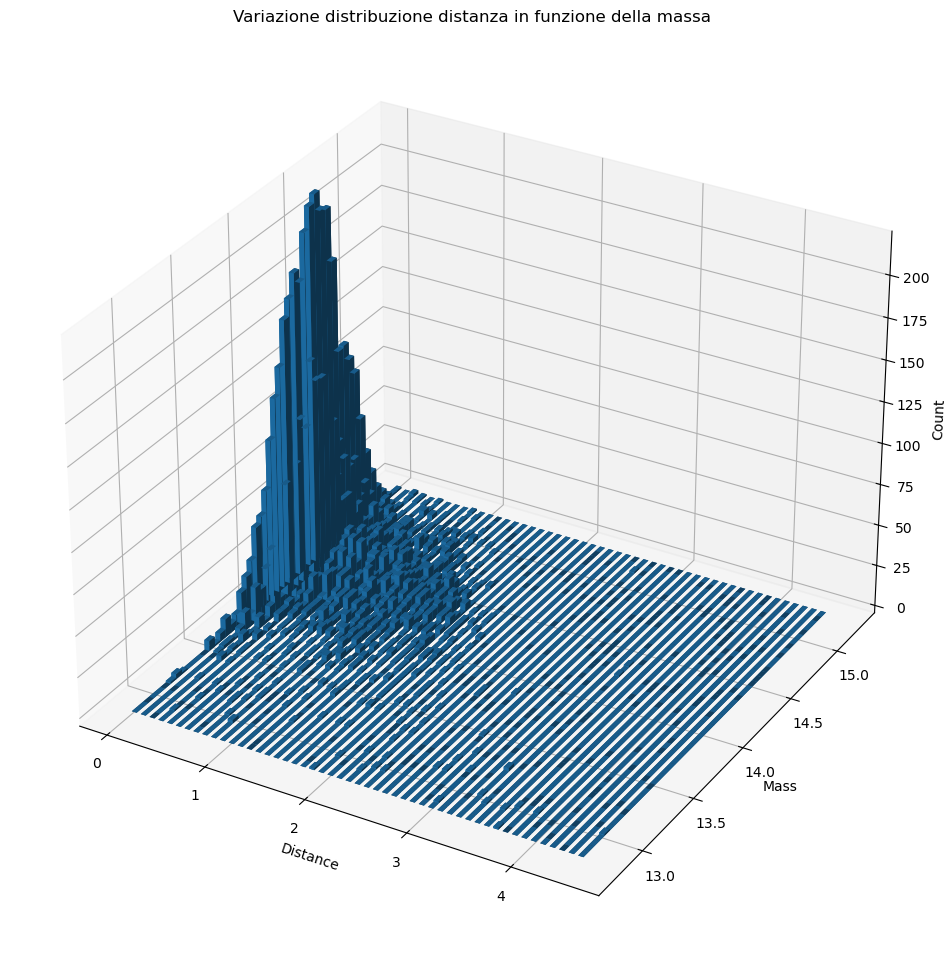

In [54]:
x = hist_mass_data.columns.map(lambda c: c.mid)
y = hist_mass_data.index.map(lambda i: i.mid)
z = hist_mass_data.values

plot_hist3D(x, y, z, 'Variazione distribuzione distanza in funzione della massa')

Istogramma dipendenza dal redshift

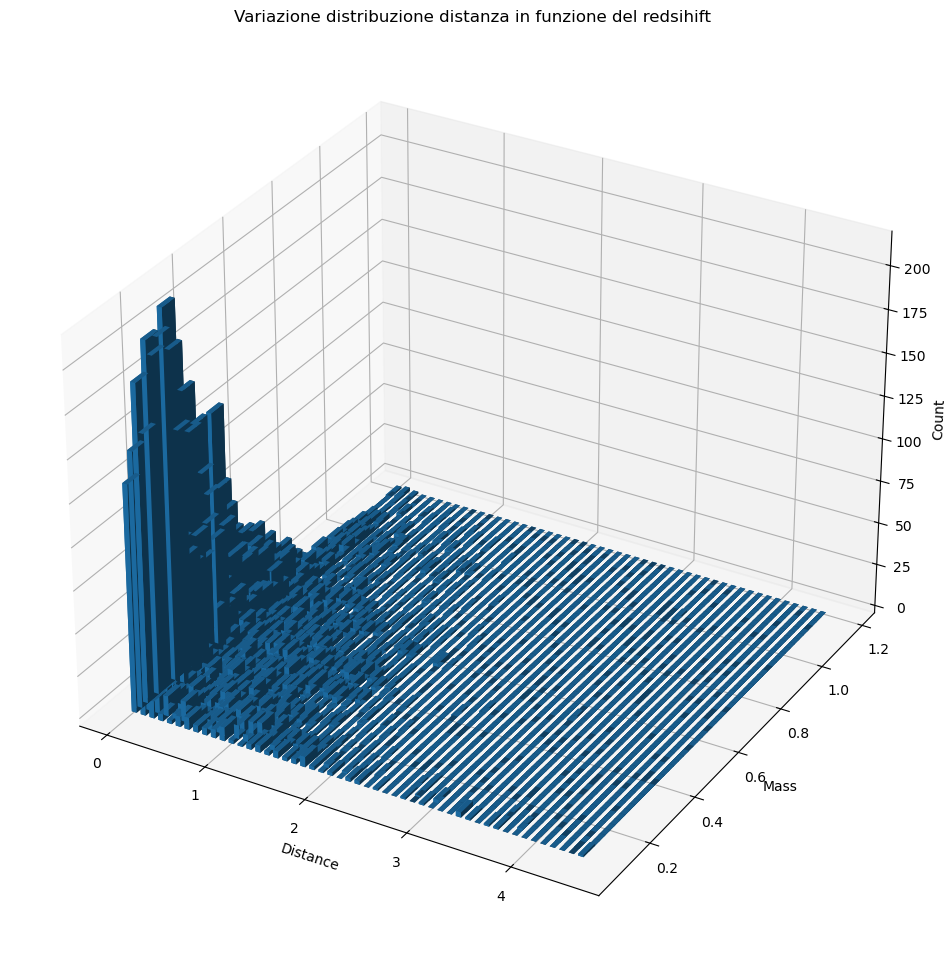

In [55]:
x = hist_z_data.columns.map(lambda c: c.mid)
y = hist_z_data.index.map(lambda i: i.mid)
z = hist_z_data.values

plot_hist3D(x, y, z, 'Variazione distribuzione distanza in funzione del redsihift')

## 2. Sviluppo dei modelli

definizione dei modelli

In [56]:
def S15(x, rho, sigma0, sigma1):
    return rho * x/sigma0**2 * np.exp(-0.5 * (x / sigma0)**2) + (1 - rho) * x/sigma1**2 * np.exp(-0.5 * (x / sigma1)**2)

def Z19(x, rho, sigma0, sigma1):
    return rho/sigma0 * np.exp(-(x / sigma0)) + (1 - rho) * x/sigma1**2 * np.exp(-(x / sigma1))


### Rappresentazione Modello S15 al variare dei parametri

In [57]:
x = np.linspace(0, 1, 100)
rho = [0.1, 0.5, 0.9]
sigma0 = [0.1, 0.3, 0.7]
sigma1 = [0.1, 0.3, 0.7]

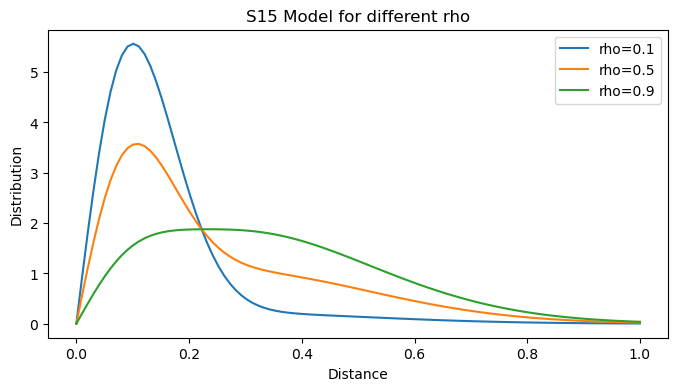

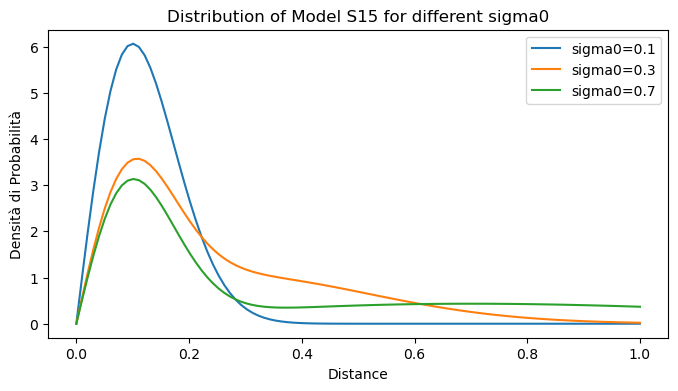

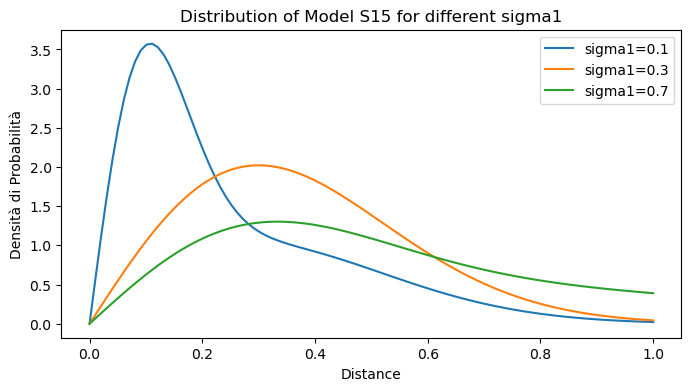

In [58]:
plt.figure(figsize=(8, 4))
for r in rho:
    plt.plot(x, S15(x, r, 0.3, 0.1), label=f'rho={r}')
plt.title('S15 Model for different rho')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()

plt.figure(figsize=(8, 4))
for s0 in sigma0:
    plt.plot(x, S15(x, 0.5, s0, 0.1), label=f'sigma0={s0}')
plt.title('Distribution of Model S15 for different sigma0')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()

plt.figure(figsize=(8, 4))
for s1 in sigma1:
    plt.plot(x, S15(x, 0.5, 0.3, s1), label=f'sigma1={s1}')
plt.title('Distribution of Model S15 for different sigma1')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()
plt.show()

- rho abbassa e allarga la distribuzione
- sig0 abbassa il primo picco
- sig1 allarga il primo picco spostandolo verso destra

### Rappresentazione del modello Z19 al variare dei parametri

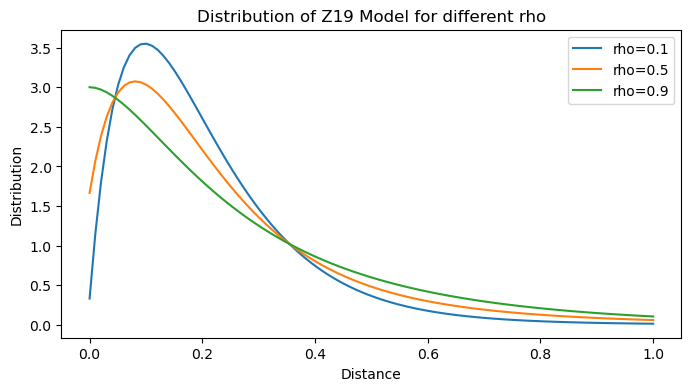

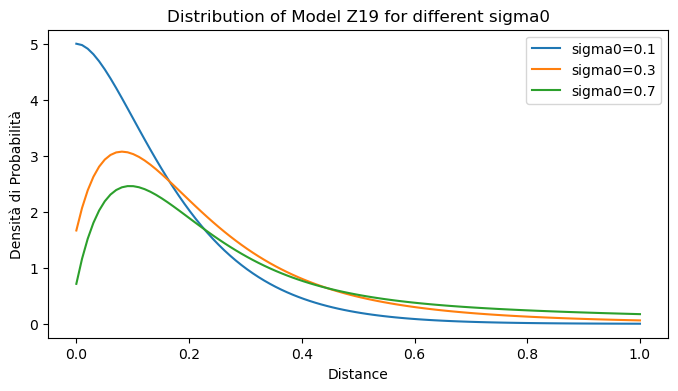

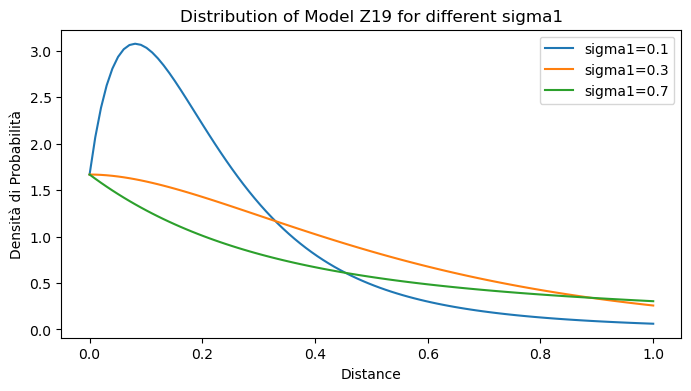

In [59]:
plt.figure(figsize=(8, 4))
for r in rho:
    plt.plot(x, Z19(x, r, 0.3, 0.1), label=f'rho={r}')
plt.title('Distribution of Z19 Model for different rho')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()

plt.figure(figsize=(8, 4))
for s0 in sigma0:
    plt.plot(x, Z19(x, 0.5, s0, 0.1), label=f'sigma0={s0}')
plt.title('Distribution of Model Z19 for different sigma0')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()

plt.figure(figsize=(8, 4))
for s1 in sigma1:
    plt.plot(x, Z19(x, 0.5, 0.3, s1), label=f'sigma1={s1}')
plt.title('Distribution of Model Z19 for different sigma1')
plt.xlabel('Distance')
plt.ylabel('Densità di Probabilità')
plt.legend()
plt.show()

- rho abbassa il primo picco e alza la coda
- sig0 abbassa il primo picco e sposta a destra
- sig1 allarga il primo picco

## 3. Analisi Bayesiana

### Modello S15

#### Fitting dei parametri con algoritmo emcee

definizione delle funzioni necessarie per l'algoritmo: prior, likelihood e posterior

In [60]:
# prior: cosa conosco dei parametri
def log_prior(theta):
    rho, sigma0, sigma1 = theta
    if sigma0>0 and sigma1>0 and 0<=rho<=1:
        return 0.0
    return -np.inf

# loglikelihood: sommatoria dei logaritmi delle distribuzioni di probabilità previste dal modello (dipende dai dati e dai parametri)
def log_likelihood(theta, x):
    rho, sigma0, sigma1 = theta
    model = S15(x, rho, sigma0, sigma1)
    return np.sum(np.log(model))

# posterior: prodotto tra prior e likelihood
def log_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x)

In [61]:
np.random.seed(42)      # random seed in modo tale da avere sempre gli stessi numeri casuali
f = lambda *args: -log_posterior(*args)

initial = np.array([0.5, 0.3, 0.3])*(1+ 0.1 * np.random.randn(3)) # parametri iniziali con random noise

soln = minimize(f, initial, args=(data['BCG_offset_R500'],))  # minimizza la funzione f (-logpost) partendo dai parametri iniziali e usando i dati come valori
rho, sigma0, sigma1 = soln.x    # estraggo i parametri ottimizzati
soln.x

c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([0.62825884, 0.06699864, 0.62301053])

In [62]:
nwalkers = 50  # numero di walkers
ndim = 3      # numero di parametri

pos = soln.x *(1+ 1e-4 * np.random.randn(nwalkers, ndim))    # definisco la posizione iniziale dei walkers per ogni parametro a partire dai parametri ottimizzati

sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data['BCG_offset_R500'],)      # inizializzo il sampler
)
sampler.run_mcmc(pos, 2000, progress=True);    # eseguo il sampling

100%|██████████| 2000/2000 [02:02<00:00, 16.32it/s]


In [63]:
flat_samples = sampler.get_chain(discard=100, flat=True)   # estraggo i valori dei parametri nei vari passi del sampling eliminando i primi 100
print(flat_samples.shape)

(95000, 3)


rappresentazione della variazione dei parametri a ogni passaggio del sampling

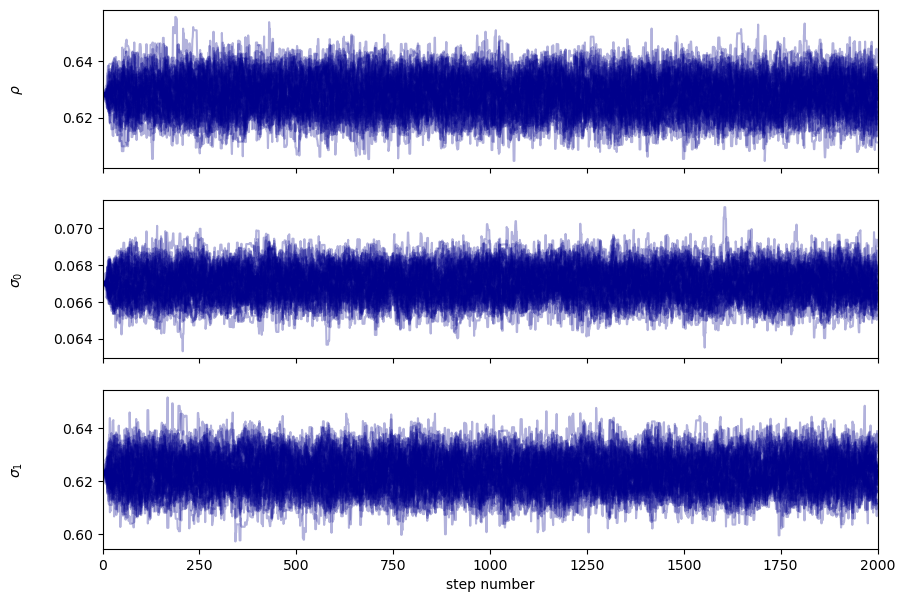

In [64]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "darkblue", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

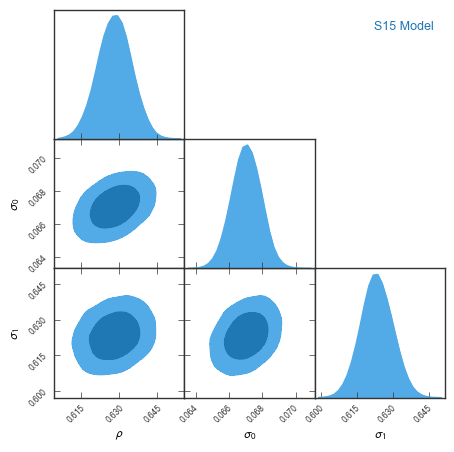

In [65]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"],
                    chainLabels=['S15 Model'],
                    figureSize='MNRAS_page')

distribuzioni marginali e correlazione dei parametri dopo il fit. Sono ottenuti a partire dai valori assunti dai walkers per ogni iterazione dopo il burn-in

#### Confronto dati-modello

In [66]:
Srho = np.median(flat_samples[:, 0])
Ssigma0 = np.median(flat_samples[:, 1])
Ssigma1 = np.median(flat_samples[:, 2])

Srho, Ssigma0, Ssigma1

(0.6283684643945111, 0.06702895849715135, 0.6230403472854399)

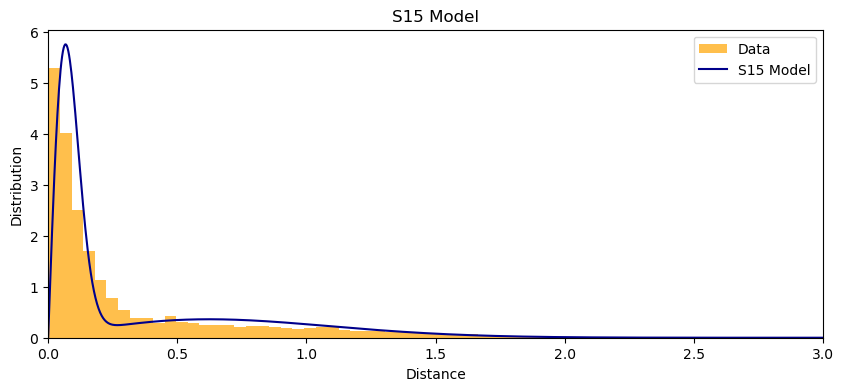

In [67]:
x = np.linspace(0, 3, 1000)

plt.figure(figsize=(10, 4))
plt.hist(data['BCG_offset_R500'], bins=100, density=True, label='Data', color='orange', alpha=0.7)
plt.plot(x, S15(x, Srho, Ssigma0, Ssigma1), label='S15 Model', color='darkblue')
plt.xlim(0, 3)
plt.title('S15 Model')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.show()

#### Valutazione della riproducibilità dei dati mediante il modello

definizione dell'algritmo del Metropolis-Hastings

In [68]:
def metropolis_hastings(target_func, proposal_func, initial_value, n_samples):
    samples = [initial_value]
    current = initial_value
    rejected = []
    for _ in range(n_samples):
        candidate = proposal_func(current)
        accept_ratio = target_func(candidate) / target_func(current)
        if np.random.rand() < accept_ratio:
            current = candidate
        else: 
            rejected.append(candidate)
        samples.append(current)
    return samples[1:],rejected

proposal

In [69]:
def proposal_func(x):
    return np.abs(np.random.normal(x,2))


approssimando la distribuzione dei parametri a una gaussiana, genero casualmente un valore di ogni parametro 

In [70]:
sig_r = np.std(flat_samples[:, 0])
sig_s0 = np.std(flat_samples[:, 1])
sig_s1 = np.std(flat_samples[:, 2])

In [71]:
target_func = lambda x: S15(x, np.random.normal(Srho, sig_r), np.random.normal(Ssigma0, sig_s0), np.random.normal(Ssigma1, sig_s1))

samples, rejected = metropolis_hastings(target_func, proposal_func, 1, 100000)

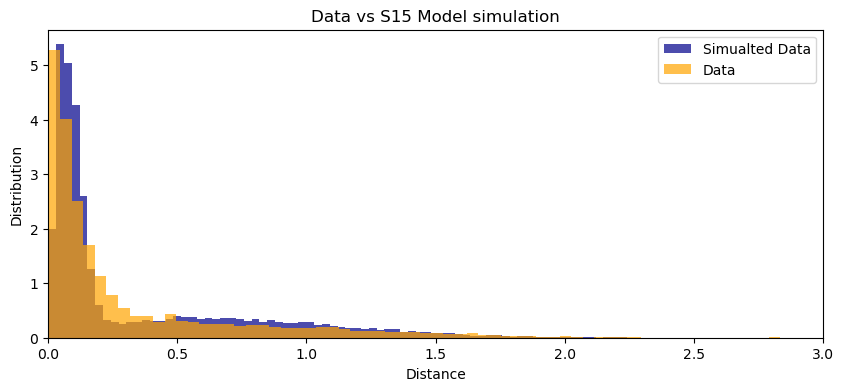

In [72]:
plt.figure(figsize=(10, 4))
plt.hist(samples, bins=100, density=True, alpha=0.7, color='darkblue', label='Simualted Data')
plt.hist(data['BCG_offset_R500'], bins=100, density=True, alpha=0.7, color='orange', label='Data')
plt.title('Data vs S15 Model simulation')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.xlim(0, 3)
plt.show()


### Modello Z19

#### Fitting dei parametri con algoritmo emcee

definizione delle funzioni necessarie per l'algoritmo: prior, likelihood e posterior

In [73]:
# prior: cosa conosco dei parametri
def log_prior(theta):
    rho, sigma0, sigma1 = theta
    if sigma0>0 and sigma1>0 and 0<=rho<=1:
        return 0.0
    return -np.inf

# loglikelihood: sommatoria dei logaritmi delle distribuzioni di probabilità previste dal modello (dipende dai dati e dai parametri)
def log_likelihood(theta, x):
    rho, sigma0, sigma1 = theta
    model = Z19(x, rho, sigma0, sigma1)
    return np.sum(np.log(model))

# posterior: prodotto tra prior e likelihood
def log_posterior(theta, x):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x)

In [74]:
np.random.seed(42)      # random seed in modo tale da avere sempre gli stessi numeri casuali
f = lambda *args: -log_posterior(*args)

initial = np.array([0.5, 0.3, 0.3])*(1+ 0.1 * np.random.randn(3)) # parametri iniziali con random noise
soln = minimize(f, initial, args=(data['BCG_offset_R500'],))  # minimizza la funzione f (-logpost) partendo dai parametri iniziali e usando i dati come valori
rho, sigma0, sigma1 = soln.x    # estraggo i parametri ottimizzati
soln.x

c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\gioch\.conda\envs\myenv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


array([0.68042444, 0.09869459, 0.39151588])

In [75]:
nwalkers = 50  # numero di walkers
ndim = 3      # numero di parametri

pos = soln.x *(1+ 1e-4 * np.random.randn(nwalkers, ndim))    # definisco la posizione iniziale dei walkers per ogni parametro

sampler = mc.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(data['BCG_offset_R500'],)      # inizializzo il sampler
)
sampler.run_mcmc(pos, 2000, progress=True);    # eseguo il sampling

100%|██████████| 2000/2000 [01:29<00:00, 22.46it/s]


In [76]:
flat_samples = sampler.get_chain(discard=100, flat=True)   # estraggo i valori dei parametri nei vari passi del sampling eliminando i primi 100
print(flat_samples.shape)

(95000, 3)


rappresentazione della variazione dei parametri a ogni passaggio del sampling

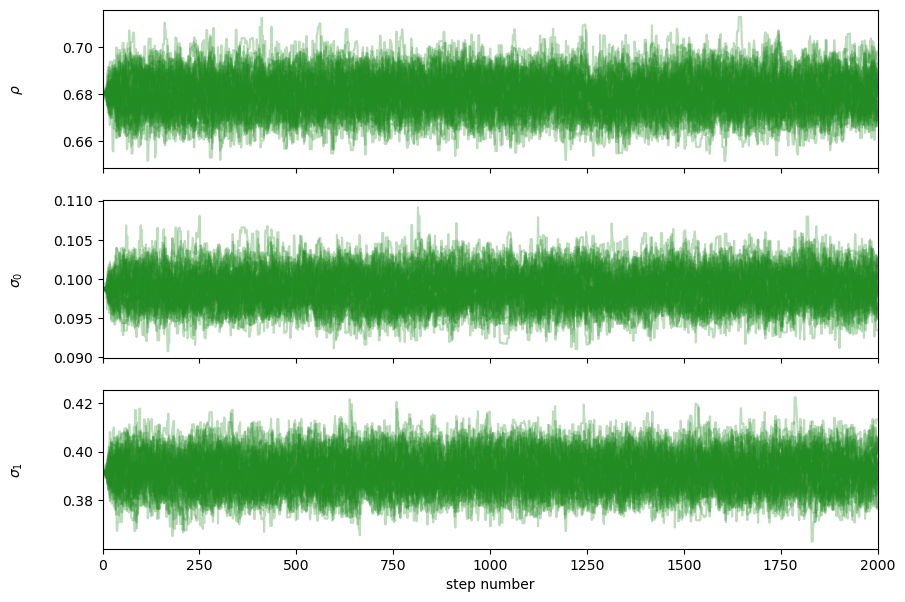

In [77]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "forestgreen", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

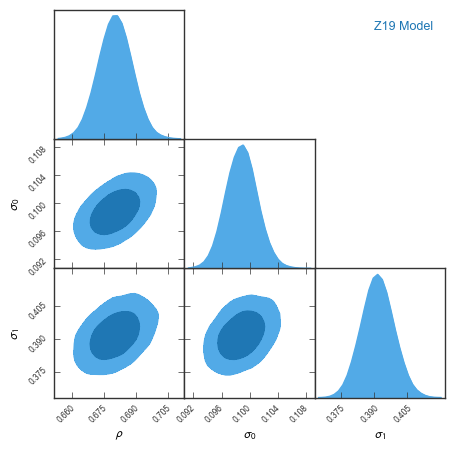

In [78]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$", r"$\sigma_0$", r"$\sigma_1$"],
                    chainLabels=['Z19 Model'],
                    figureSize='MNRAS_page')

distribuzioni marginali e correlazione dei parametri dopo il fit. Sono ottenuti a partire dai valori assunti dai walkers per ogni iterazione dopo il burn-in

#### Confronto dati-modello

In [79]:
Zrho = np.median(flat_samples[:, 0])
Zsigma0 = np.median(flat_samples[:, 1])
Zsigma1 = np.median(flat_samples[:, 2])

Zrho, Zsigma0, Zsigma1

(0.6801957433727301, 0.09881392627269925, 0.3916523835548002)

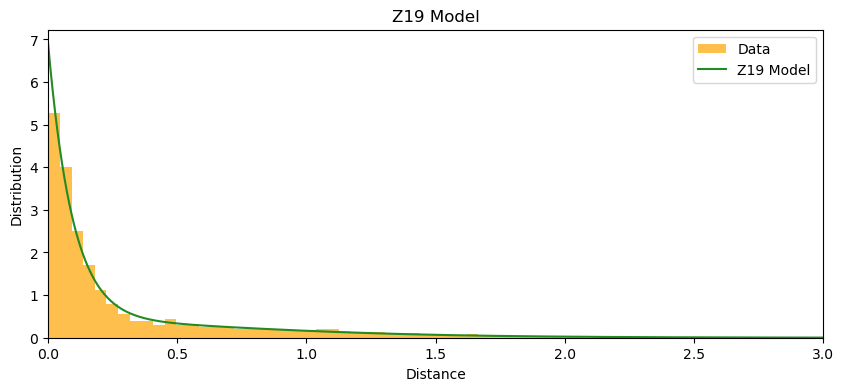

In [80]:
x = np.linspace(0, 3, 1000)

plt.figure(figsize=(10, 4))
plt.hist(data['BCG_offset_R500'], bins=100, density=True, label='Data', color='orange', alpha=0.7)
plt.plot(x, Z19(x, zrho, zsigma0, zsigma1), label='Z19 Model', color='forestgreen')
plt.xlim(0, 3)
plt.title('Z19 Model')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.show()

#### Valutazione della riproducibilità dei dati mediante il modello

applicazione con proposal normale

In [81]:
Zsig_r = np.std(flat_samples[:, 0])
Zsig_s0 = np.std(flat_samples[:, 1])
Zsig_s1 = np.std(flat_samples[:, 2])

In [82]:
target_func = lambda x: Z19(x, np.random.normal(Zrho, Zsig_r), np.random.normal(Zsigma0, Zsig_s0), np.random.normal(Zsigma1, Zsig_s1))

samples, rejected = metropolis_hastings(target_func, proposal_func, 1, 100000)

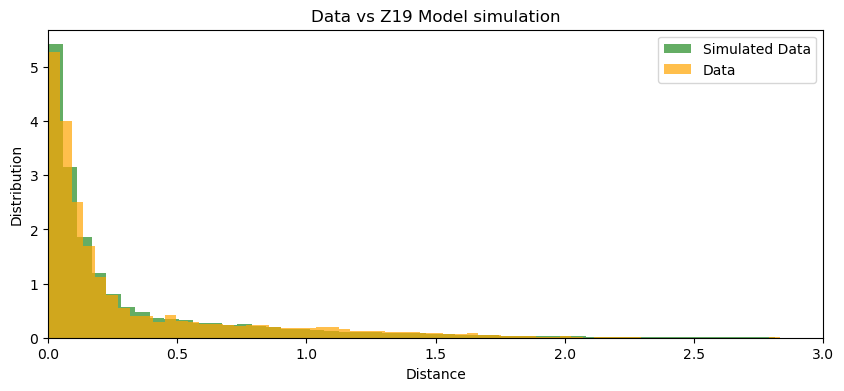

In [83]:
plt.figure(figsize=(10, 4))
plt.hist(samples, bins=100, density=True, alpha=0.7, color='forestgreen', label='Simulated Data')
plt.title('Data vs Z19 Model simulation')
plt.hist(data['BCG_offset_R500'], bins=100, density=True, alpha=0.7, color='orange', label='Data')
plt.xlabel('Distance')
plt.ylabel('Distribution')
plt.legend()
plt.xlim(0, 3)
plt.show()